# Oversold Mean Reversion Strategy

In [1]:
import sys
from pathlib import Path

import matplotlib
if not hasattr(matplotlib.rcParams, '_get'):
    matplotlib.rcParams._get = matplotlib.rcParams.get

import matplotlib.pyplot as plt
import pandas as pd

project_root = Path('..').resolve()
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from data_loader import load_ohlcv_csv
from backtest import run_backtest
from qflib_metrics import qflib_metrics_from_returns
from strategy_oversold import oversold_signals


In [2]:
df = load_ohlcv_csv('../data/OKX_BTCUSDT, 1D.csv')
df[['close', 'Oversold HWO Up', 'Overbought HWO Down']].head()


,close,Oversold HWO Up,Overbought HWO Down
time,,,
2025-01-17 00:00:00+00:00,104084.4,NaN,NaN
2025-01-18 00:00:00+00:00,104551.6,NaN,NaN
2025-01-19 00:00:00+00:00,101334.0,NaN,NaN
2025-01-20 00:00:00+00:00,102264.3,NaN,NaN
2025-01-21 00:00:00+00:00,106150.1,NaN,NaN


In [3]:
signal_cols = ['Oversold HWO Up', 'Overbought HWO Down']
df[signal_cols] = df[signal_cols].fillna(0.0)
df[signal_cols].tail()


,Oversold HWO Up,Overbought HWO Down
time,,
2025-11-08 00:00:00+00:00,16.989438,0.0
2025-11-09 00:00:00+00:00,0.000000,0.0
2025-11-10 00:00:00+00:00,0.000000,0.0
2025-11-11 00:00:00+00:00,0.000000,0.0
2025-11-12 00:00:00+00:00,0.000000,0.0


In [4]:
positions = oversold_signals(df)
positions.value_counts()


position
0.0    219
1.0     81
Name: count, dtype: int64

In [5]:
bt = run_backtest(df.copy(), positions)
bt[['strategy_ret', 'equity_curve']].tail()


,strategy_ret,equity_curve
time,,
2025-11-08 00:00:00+00:00,-0.000000,9621.509221
2025-11-09 00:00:00+00:00,0.023478,9847.405713
2025-11-10 00:00:00+00:00,0.012314,9968.671215
2025-11-11 00:00:00+00:00,-0.027830,9691.244408
2025-11-12 00:00:00+00:00,0.002067,9711.273527


In [6]:
metrics = qflib_metrics_from_returns(bt['strategy_ret'])
metrics_df = pd.DataFrame([metrics], index=['Oversold_MR'])
metrics_df


,total_return,cagr,sharpe_ratio,annualised_vol,max_drawdown,avg_drawdown_duration
Oversold_MR,-0.028873,-0.02431,0.020407,0.243754,-0.223563,91.0


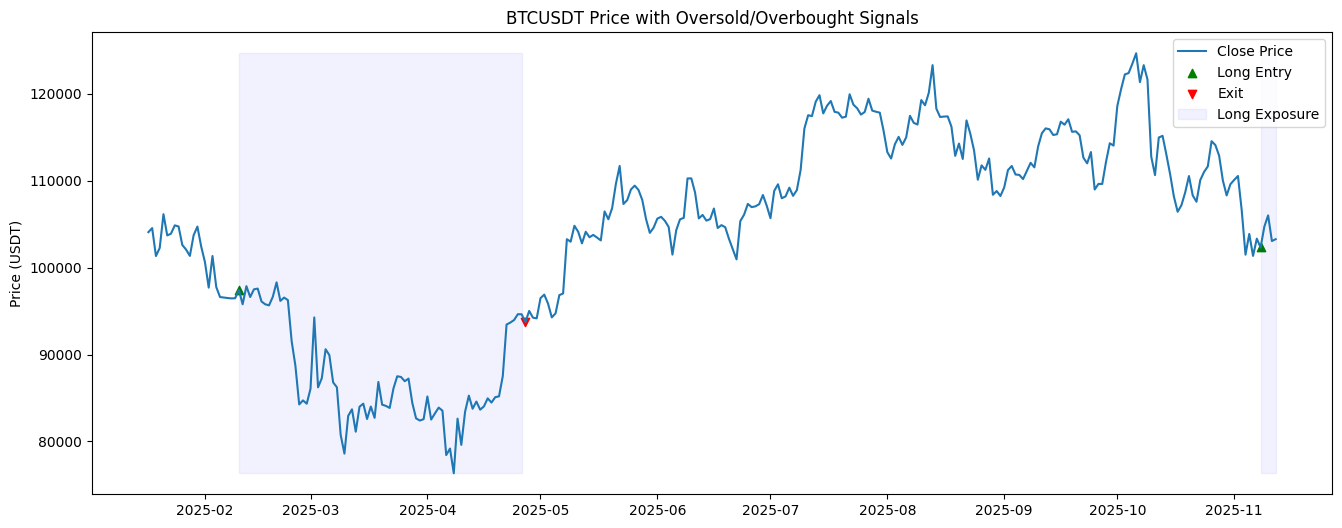

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.index, df['close'], label='Close Price')
entries = positions.diff().fillna(0) > 0
exits = positions.diff().fillna(0) < 0
ax.scatter(df.index[entries], df.loc[entries, 'close'], marker='^', color='green', label='Long Entry')
ax.scatter(df.index[exits], df.loc[exits, 'close'], marker='v', color='red', label='Exit')
ax.fill_between(df.index, df['close'].min(), df['close'].max(), where=positions > 0.5, color='blue', alpha=0.05, label='Long Exposure')
ax.set_title('BTCUSDT Price with Oversold/Overbought Signals')
ax.set_ylabel('Price (USDT)')
ax.legend()
plt.show()


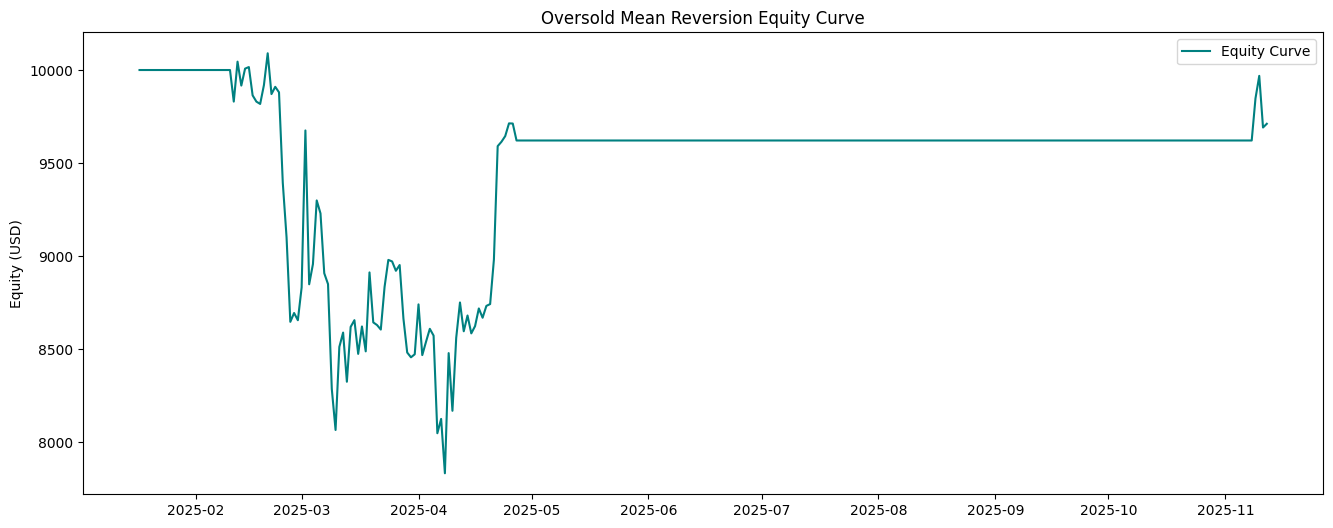

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(bt.index, bt['equity_curve'], label='Equity Curve', color='teal')
ax.set_title('Oversold Mean Reversion Equity Curve')
ax.set_ylabel('Equity (USD)')
ax.legend()
plt.show()
